#### Split Test  Analysis

Working on Cobra Kai, a fictional combat card game, you recently introduced a new special bundle containing various characters as an A/B/C/D pricing test.

Given the test details below, and the data included in the tab 'SECTION 2 DATA', please analyze the results of the test and provide recommendations on further actions.	
	
| Group &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  | Split&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Price&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Discount Ratio |
|:---    |-------|-------|----------------|
| Control | 10%   | N/A   | N/A            |
| Case A  | 30%   | $2,99 | 50%            |
| Case B  | 30%   | $6,99 | 50%            |
| Case C  | 30%   | $9,99 | 50%            |

&nbsp;  
• The test ran for 30 days on iOS only, targeting all users, starting on the 15/03/2017  
• The data includes 14 days before the start of the test, from 01/03 to 14/03  
• The bundle composition was adapted to provide the same discount value to each user  
• The car quality, type and class split were kept the same across the different bundles  
• The bundles consisted of completely new cars, which were only available to buy through these offers  
• The normal *HC packs of the game are priced \$ 1.99 / \$ 4.99 / \$ 9.99 / \$ 19.99 / \$ 49.99 / \$ 99.99  

**HC=hard currency (currency purchased with real money)*


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [24]:
# Importing the processed data
df = pd.read_csv('./files/data/data_processed.csv')
df.head()

,Date,Group,DAU,Revenue,PAU/DAU,PAU,ARPU,ARPPU,Transactions,Car bundle A // 2.99$,...,Pack 1 // 1.99$,Pack 2 // 4.99$,Pack 3 // 9.99$,Pack 4 // 19.99$,Pack 5 // 49.99$,Pack 6 // 99.99$,Card bundle promotion,Promotions_sold,Sales not in promotion,Timing
0,03/01/2017,control,343970,19794,0.007492,2577,0.057546,7.681024,5238.402004,0,...,1484.0,1356.0,2745.0,4950.0,3391.0,5868.0,0,0.0,19794,Previous
1,03/02/2017,control,340743,16067,0.007118,2426,0.047153,6.622836,4416.350040,0,...,1051.0,1183.0,2290.0,3978.0,2704.0,4861.0,0,0.0,16067,Previous
2,03/03/2017,control,399292,16212,0.007807,3117,0.040602,5.201155,5564.455360,0,...,977.0,1205.0,2208.0,4078.0,2827.0,4917.0,0,0.0,16212,Previous
3,03/04/2017,control,413060,16824,0.007345,3034,0.040730,5.545155,5485.192860,0,...,1303.0,1235.0,2354.0,4145.0,2792.0,4995.0,0,0.0,16824,Previous
4,03/05/2017,control,388422,18257,0.006887,2675,0.047003,6.825047,4846.145624,0,...,1065.0,1298.0,2535.0,4619.0,3188.0,5552.0,0,0.0,18257,Previous


In [26]:
df.set_index('Date', inplace=True)

In [27]:
# Generating list of the groups 
group_list = list(df['Group'].unique())
group_list

['control', 'Case A', 'Case B', 'Case C']

In [28]:
# Separating the groups into different datframes to use in visualizations
groups = {i: df[df['Group']==i] for i in group_list}

df_control = groups['control']
df_A = groups['Case A']
df_B = groups['Case B']
df_C = groups['Case C']

# List with all the dataframes
df_list = [df_control, df_A, df_B, df_C]

In [29]:
# Creating dataframe that show mean values for the metrics before and during the experiment
df_mean = df.groupby(['Group', 'Timing'])[['DAU', 'Revenue', 'Transactions', 'PAU/DAU', 'PAU', 'ARPU', 'ARPPU']].agg('mean')
df_mean.sort_index(level=['Group', 'Timing'], ascending=[True, False], inplace=True)

# Saving to csv
df_mean.to_csv('files/mean_metrics.csv')

# Formatting the dataframe for a better reading
df_mean.style.format({'DAU': '{:,.0f}', 'Revenue': '{:,.0f}', 'Transactions': '{:,.0f}',
'PAU/DAU': '{:,.3%}', 'PAU': '{:,.0f}', 'ARPU': '${:,.3f}', 'ARPPU': '{:,.3f}'})

In [30]:
# Defining function to compare metrics before and during the experiment

def change_ratio(col):
    df = df_mean[col].reset_index().pivot(index='Group',columns='Timing',values=col)
    df = df[['Previous', 'Post']]
    df['change_ratio']=((df['Post']/df['Previous']-1)*100).apply('{:.2f}%'.format)
    return df

### Visualizations
We’ll plot the metrics of interest using a 5-day rolling window mean on most of the curves to soften them and make it easier to analyze the results across the groups.

To start, let’s check the Revenue.


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


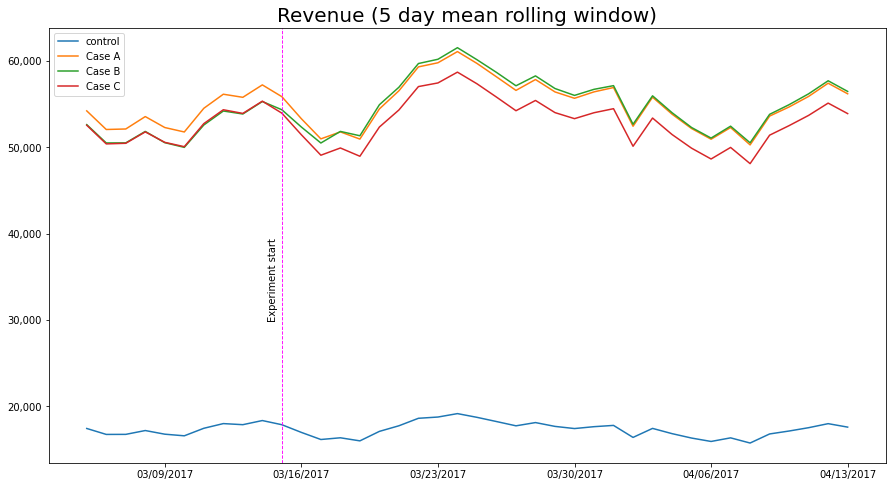

In [31]:
# Plotting Revenue for all the cases (5 day mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['Revenue'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,30000,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('Revenue (5 day mean rolling window)')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.savefig('./files/Revenue_rolling.png')

Given that the control group only had 10% of the users split, this chart will be useful just to compare the Cases A, B and C.  
We can see that the users didn’t engage with the experiment as soon as it started; it took a couple of days to make a difference in the revenue.  
We start to see that there’s a difference in performance for the test cases. Cases A and B were clearly superior to Case C in this Revenue.

The mean of the revenues before and during the experiment (before March 15 and from March 15 until the end) were as follows:


In [32]:
df_revenue = change_ratio('Revenue')

# Formatting the dataframe for a better reading
df_revenue.style.format({'Previous': '{:,.0f}', 'Post': '{:,.0f}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,"54,423","55,126",1.29%
Case B,"52,658","55,444",5.29%
Case C,"52,684","52,852",0.32%
control,"17,463","17,265",-1.13%


Case B was the group that most grew in revenue. Revenue for cases A and C also went up during the experiment, but quite less than group B. On the other hand, the control group experienced a decrease in revenue.  
We must keep in mind that this is not the only important metric, we must keep digging into the other measurements in order to get insights.  

Let’s check one of the most important monetization metrics now, the ARPU.

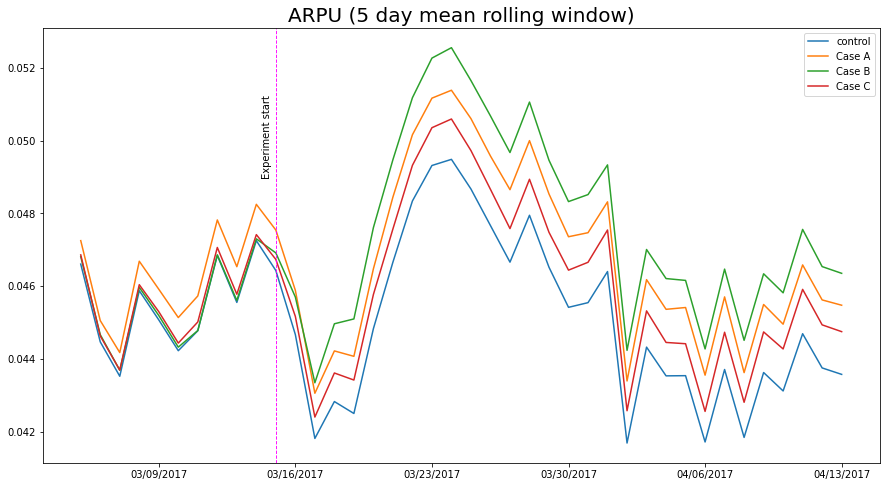

In [33]:
# Plotting ARPU for all the cases (5 day mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['ARPU'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,0.049,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('ARPU (5 day mean rolling window)')

plt.savefig('./files/ARPU_rolling.png')

This chart is quite insightful. As we saw in the revenue, the first couple of days the users seem a bit reluctant to spend their money, but roughly 5 days in the experiment, we can see a really big rise in the monetization per user, group B being the most profitable.  

On the other hand, we can see the control group also rising on day 5, so there’s definitely other factors into play. By the end of the cart, we can see the ARPU getting back (on average) to levels similar to the days before the experiment. We must note that the control group seems to have a lower ARPU than before the experiment.  
Other thing to note is that on the first days of April the ARPU went down across all groups.

We must look into the next table with the mean ARPU before and during the experiment for the different groups.


In [34]:
df_ARPU = change_ratio('ARPU')

# Formatting the dataframe for a better reading
df_ARPU.style.format({'Previous': '${:,.4f}', 'Post': '${:,.4f}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,$0.0471,$0.0465,-1.19%
Case B,$0.0464,$0.0475,2.42%
Case C,$0.0465,$0.0457,-1.61%
control,$0.0463,$0.0447,-3.36%


It’s a bit surprising that almost all of the groups had a lower mean ARPU during the experiment than the days before, the control group standing out in this trend. On the other hand, group B was the only group to have a better ARPU during the experiment.
We must not rely on the ARPU by itself, as this metric is composed by revenue and active users, so a lower ARPU might not be too bad if there are much more players in the game. That being said, let’s check the DAU.


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


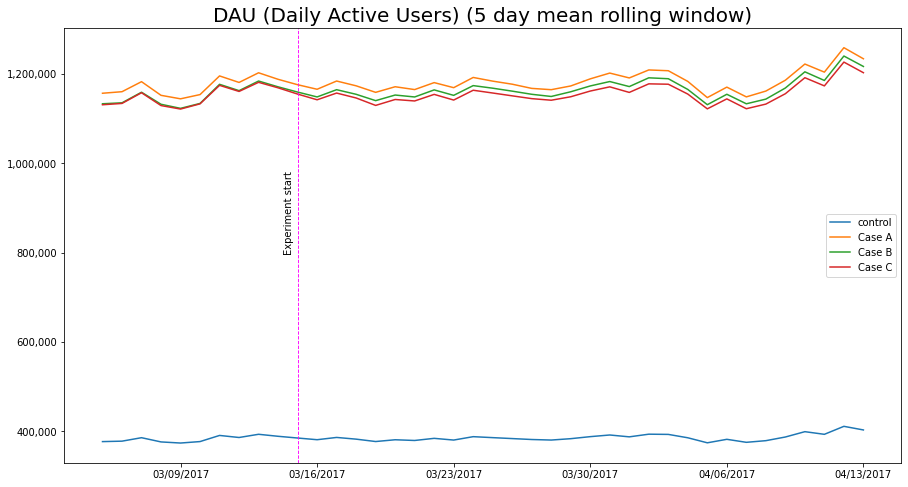

In [35]:
# Plotting DAU for all the cases (5 day mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['DAU'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,0.8*10**6,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('DAU (Daily Active Users) (5 day mean rolling window)')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.savefig('./files/DAU_rolling.png')

First of all, DAU by itself won’t be really useful, but we can get more value out of this metric by comparing to others, such as PAU.  

Case A went better for the Daily Active Users. If we check the curves, we can see that the Case A had a higher DAU even before the experiment started, so it could be just chance that this group had more active users. We can see that group B was quite similar to group C before the experiment, but as soon as it started, they split up favoring group B over C. 

The mean of the DAU before and during the experiment for the different groups were these:


In [36]:
df_DAU = change_ratio('DAU')

# Formatting the dataframe for a better reading
df_DAU.style.format({'Previous': '{:,.0f}', 'Post': '{:,.0f}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,"1,161,388","1,188,286",2.32%
Case B,"1,141,194","1,171,115",2.62%
Case C,"1,139,410","1,159,504",1.76%
control,"379,395","387,448",2.12%


The comparison of the DAUs before and during the experiment shows that every group went up. Two things get my attention.  
First, as in the Revenue analysis, the group B is again at the top. The other thing is, even though group C went up in DAU, the control group had a better percent change. This could mean that the promotion given to the group C might be discouraging the users to play the game.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


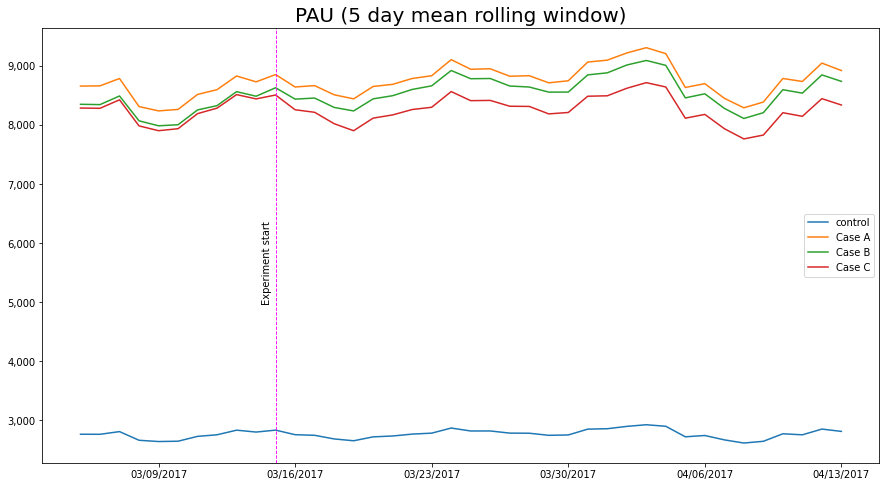

In [37]:
# Plotting PAU for all the cases (5 day mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['PAU'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,5000,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('PAU (5 day mean rolling window)')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.savefig('./files/PAU_rolling.png')

Something similar to the DAU happened in the PAU; there’s a slight superiority in the Case A, but as this trend started before the experiment.  
We can see again the split between groups B and C when the experiment starts this time is more remarkable, though. Group B started similar to group C, but it rose at almost the level of group A as the experiment went on.  

The mean of the PAU before and during the experiment for the different groups were as follows:


In [38]:
df_PAU = change_ratio('PAU')

# Formatting the dataframe for a better reading
df_PAU.style.format({'Previous': '{:,.0f}', 'Post': '{:,.0f}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,"8,560","8,801",2.82%
Case B,"8,292","8,613",3.87%
Case C,"8,231","8,250",0.22%
control,"2,741","2,772",1.12%


In the table above, we can see the notorious growth in the PAU for group B, more than tripling the control group growth. Group B has a slightly lower mean PAU during the experiment than group A, but shows the highest rising ratio of all groups.  

Group A also performing good in this metric. It had the highest PAU before the experiment, and showed a pretty good rise, too.  

Let’s look into the PAU/DAU ratio now.


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


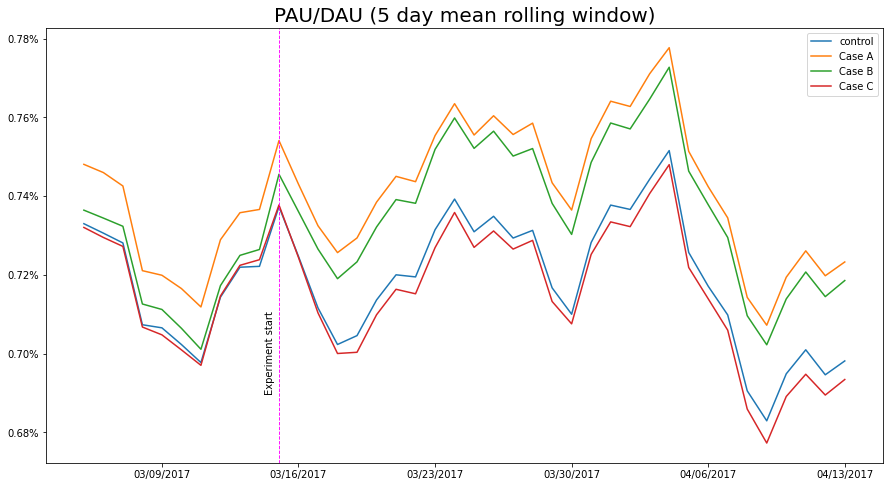

In [39]:
# Plotting PAU/DAU for all the cases (5 day mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['PAU/DAU'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,0.0069,'Experiment start',rotation=90)

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.2%}'.format(x) for x in current_values])

plt.rcParams['axes.titlesize']=20
plt.title('PAU/DAU (5 day mean rolling window)')

plt.savefig('./files/PAU-DAU_rolling.png')

The ratio of the paid users against the total users doesn’t seem to have great changes during the experiment.  

The mean of the PAU/DAU ratio before and during the experiment for the different groups were as follows:


In [40]:
df_PAUDAU = change_ratio('PAU/DAU')

# Formatting the dataframe for a better reading
df_PAUDAU.style.format({'Previous': '{:,.3%}', 'Post': '{:,.3%}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,0.737%,0.741%,0.47%
Case B,0.727%,0.736%,1.19%
Case C,0.723%,0.712%,-1.53%
control,0.723%,0.716%,-1.00%


Slight growth for the PAU/DAU ratio in groups A and B, especially the latter.  
Control group and Group C experiencing a decrease in this ratio.  

Group C particularly was the one with the biggest decrease. Despite there was a rise in it’s DAU, the ratio of users willing to pay is notoriously going down.  

Let’s take a look into AARPU.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


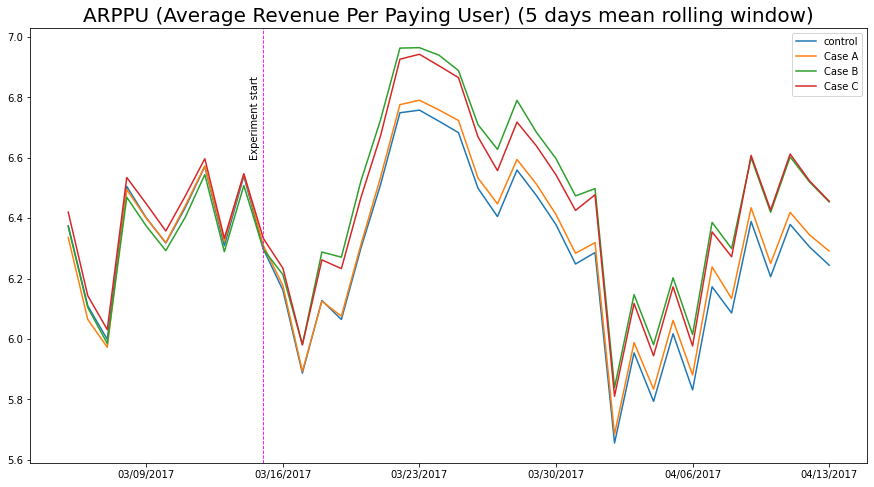

In [41]:
# Plotting ARPPU (Average Revenue Per Paying User) for all the cases (5 days mean rolling window)

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['ARPPU'].rolling(5).mean())

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,6.6,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('ARPPU (Average Revenue Per Paying User) (5 days mean rolling window)')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.1f}'.format(x) for x in current_values])

plt.savefig('./files/ARPPU_rolling.png')

This is interesting. Group C was the weaker one in almost all metrics except this. Even since before the experiment, group C was at the top of ARPPU, meaning that the paid users were the ones that more spend on average across all groups. This tendency was reverted when the experiment started and group B paid users started spending more money on average than group C, although when reaching the end of the experiment, groups B and C had almost the same ratio.  

Same as the ARPU, the first days of April, ARPPU seems quite low across all groups; there has to be a reason behind the fact that users were reluctant to spend too much money on the game those days. Maybe it was a special date that most people spends their money on something else.

The mean of the ARPPU before and during the experiment for the different groups were as follows:

In [42]:
f_ARPPU = change_ratio('ARPPU')

# Formatting the dataframe for a better reading
df_ARPPU.style.format({'Previous': '${:,.3f}', 'Post': '${:,.3f}'})

Timing,Previous,Post,change_ratio
Group,,,
Case A,$6.400,$6.293,-1.68%
Case B,$6.389,$6.466,1.21%
Case C,$6.442,$6.437,-0.08%
control,$6.411,$6.257,-2.39%


Looking into these results, we can see that despite our first impression on the ARPPU of group C, the mean went down a little compared to the days before the experiment. This happened in almost all groups. Group B once again showing a rise on this metric.  

Last charts we’ll look at are the sales of the promotion bundles for each group, first the sales amount, then the number of promotion bundles sold.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


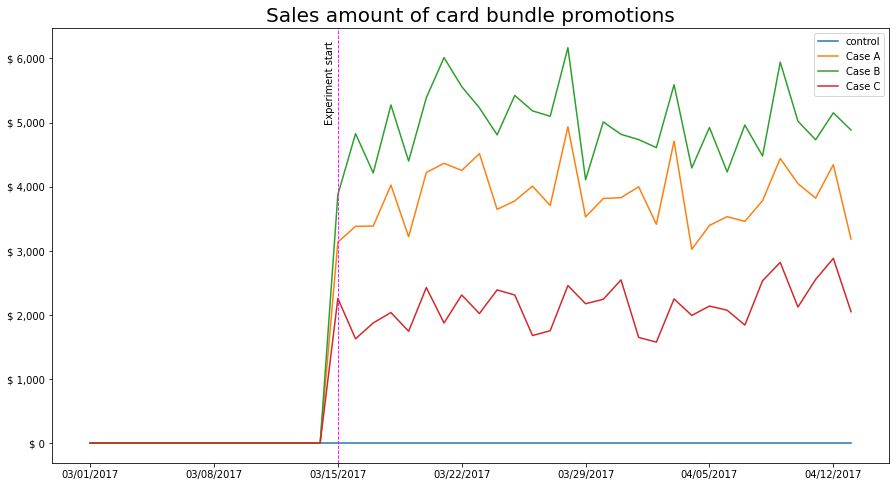

In [43]:
# Plotting Card bundles sold in promotion

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['Card bundle promotion'])

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,5000,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('Sales amount of card bundle promotions')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['$ {:,.0f}'.format(x) for x in current_values])

plt.savefig('./files/Promotions_sold.png')

It seems that the promotion offered to group B was the best one in terms of sales amount. Users spent more money on the promotion bundle for group B. This doesn’t mean that it had the highest number of promotion bundles sold, but it was the one which made more money.

Let’s check the most sold packs now.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


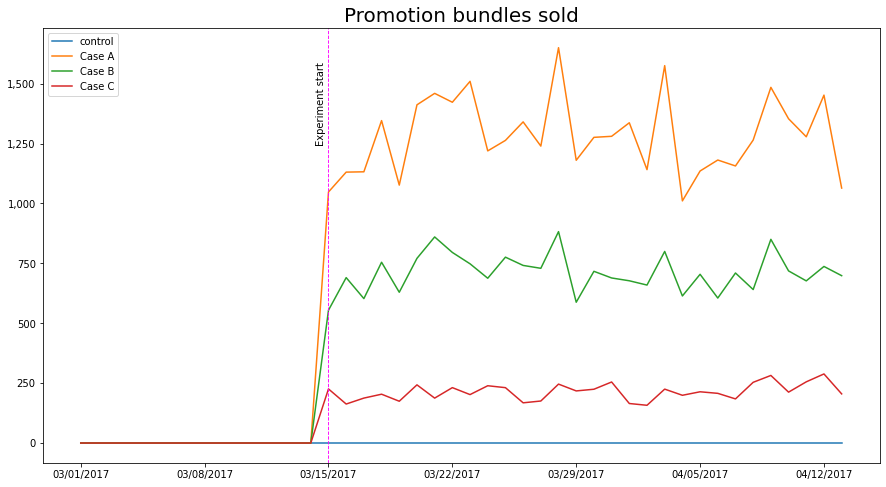

In [44]:
# Plotting number of promotion bundles sold

fig, ax = plt.subplots(figsize=(15,8))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

for i in df_list:
    ax.plot(i['Promotions_sold'])

plt.gca().legend(tuple(group_list))
plt.axvline(x="03/15/2017", c='magenta', ls='--', lw=0.9)
plt.text(13.3,1250,'Experiment start',rotation=90)
plt.rcParams['axes.titlesize']=20
plt.title('Promotion bundles sold')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.savefig('./files/Promotion_bundles_sold.png')

It was somehow predictable. The cheapest the promotion, the higher number of sales. But as we saw in the previous chart, the group A reported less profit than the group B because of the bundle prices.

#### Conclusions

As we saw in most of the metrics, group B reported the best results of the experiment. Despite group A reporting the highest revenue, it was a trend coming from before the experiment. If we analyze the ratio of the change in revenue, group B outperformed group A in this, too.

Some questions that may arise are:
-	What will the experiment longer-term effects be? How do each group behave after the experiment?
-	What will be the impact on retention metrics?
-	How will the experiment affect monetization after it ends?

As final recommendation, I would suggest to keep tracking the behavior of the users of each group to see if what are the lasting effects of the experiment. I would pay special attention to engagement metrics, so it would be helpful to track some other metrics that weren’t on the original experiment, such as DAU/MAU (stickiness) and retention and churn rates. Of course, monetization metrics would be important, too, so we might as well keep an eye on the metrics that were present in the test along with others like conversion rates.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c0f6dcf0-1a26-4fa8-bfda-9393dc33e48a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>